In [1]:
import mmf_setup;mmf_setup.nbinit()
import matplotlib.pyplot as plt
%pylab inline --no-import-all
from nbimports import *
import numpy as np

<IPython.core.display.Javascript object>

In [2]:
import mmf_hfb.BCSCooling as bcsc; reload(bcsc)
from mmf_hfb.BCSCooling import BCSCooling
from mmf_hfb.SolverABM import ABMEvolverAdapter
from mmf_hfb.Cooling import Cooling
from mmf_hfb.Potentials import HarmonicOscillator
from IPython.core.debugger import set_trace
from IPython.display import display, clear_output
import numpy as np
import scipy as sp

def Normalize(psi, dx=0.1):
    return psi/(psi.dot(psi.conj())*dx)**0.5

def Prob(psi):
    return np.abs(psi)**2
   
def check_uv_ir_error(x, psi, plot=False):
    """check if a lattice configuration(N, L, dx) is good"""
    psi_k = np.fft.fft(psi)
    psi_log = np.log10(abs(psi))
    psi_log_k = np.log10(abs(psi_k))
    if plot:
        l, =plt.plot(x,psi_log_k)
        plt.plot(x, psi_log,'--', c=l.get_c())
        print(np.min(psi_log), np.min(psi_log_k))
    assert np.min(psi_log_k) < -15

-17.7887019787572 -inf


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


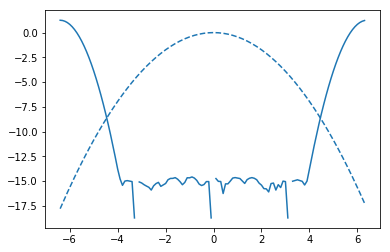

In [3]:
N, dx = 128, 0.1
args = dict(N=N, dx=dx, divs=(1, 1), beta0=1, beta_K=0, beta_V=0, beta_D=0, beta_Y=0, T=0, check_dE=False)
b = BCSCooling(**args)
x = b.xyz[0]
gaussian = np.exp(-x**2)
check_uv_ir_error(x=x, psi=gaussian, plot=True)

In [13]:
def test_cooling(plot_dE=True,  use_ABM=False, T=0.5, **args):   
    b = BCSCooling(**args)
    solver = ABMEvolverAdapter if use_ABM else None
    h0 = HarmonicOscillator(w=1)
    h = HarmonicOscillator()
    da, db=b.divs    
    x = b.xyz[0]
    V = x**2/2
    H0 = b._get_H(mu_eff=0, V=0)
    H1 = b._get_H(mu_eff=0, V=V)
    U0, E0 = b.get_U_E(H0, transpose=True)
    U1, E1 = b.get_U_E(H1, transpose=True)
    psi0 = h.get_wf(x)
    psi0 = U1[0]
    psi0 = Normalize(psi0, dx=b.dx)
    psi = h0.get_wf(x, n=2)
    psi = U0[1]
    psi = Normalize(psi, dx=b.dx)
    #b.erase_max_ks()
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    ts, psiss = b.solve([psi], T=T, rtol=1e-5, atol=1e-6, V=V,solver=solver, method='BDF')    
    E0, _ = b.get_E_Ns([psi0], V=V)
    Es = [b.get_E_Ns([_psi], V=V)[0] for _psi in psiss[0]]
    dE_dt= [-1*b.get_dE_dt([_psi], V=V) for _psi in psiss[0]]
    plt.plot(x, Prob(psiss[0][0]), "+", label='init')
    plt.plot(x, Prob(psiss[0][-1]), '--',label="final")
    plt.plot(x, Prob(psi0), label='Ground')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(ts[0][:-2], (Es[:-2] - E0)/abs(E0), label="E")
    if plot_dE:
        plt.plot(ts[0][:-2], dE_dt[:-2], label='-dE/dt')
        plt.axhline(0, linestyle='dashed')
    plt.legend()
    plt.axhline(0, linestyle='dashed')
    plt.show()    
    return psiss[0][-1]

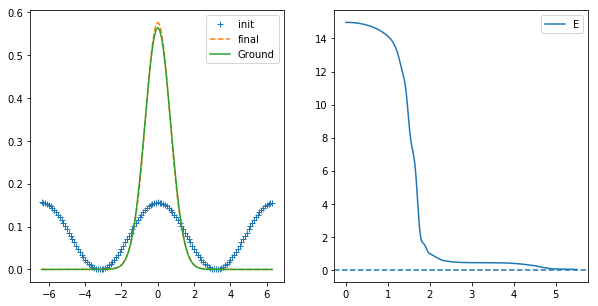

Wall time: 15.3 s


In [14]:
%%time 
args = dict(N=128, dx=0.1,beta0=1, beta_K=0, beta_V=1, beta_D=0, beta_Y=0, T=5.5, divs=(1, 1), use_ABM=False, check_dE=False)
psi = test_cooling(plot_dE=False, **args)